In [7]:
from google.colab import drive
import sys, os
drive.mount('/content/drive')
!pip install torch_geometric -q

Mounted at /content/drive


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import pickle
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, classification_report
from torch_geometric.loader import DataLoader
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import warnings
import time

warnings.filterwarnings('ignore')
warnings.filterwarnings(
    "ignore",
    message=r".*accelerated via the 'torch-scatter' package.*"
)


In [15]:

print("EIT crack localization, gnn evaluation ")


# Setup paths and imports
base_path = '/content/drive/MyDrive/Sara_Albeyrouti_Thesis'
sys.path.insert(0, base_path)

for folder in ['data', 'models', 'plots']:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

from graphnn import config, EIT_Localization_GNN, EIT_GNN_Dataset

threshold = 0.10
distance_threshold = [0.05, 0.10, 0.15, 0.20, 0.25]

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"grid Configuration: {config.grid_size_x}×{config.grid_size_y}")
print(f"maximum Cracks: {config.max_cracks}")
print(f"primary Threshold: {threshold}")

# Create plots directory
plot_dir = os.path.join(base_path, config.plot_dir, 'evaluation')
os.makedirs(plot_dir, exist_ok=True)

print(f"plots will be saved to: {plot_dir}")

EIT crack localization, gnn evaluation 
grid Configuration: 10×10
maximum Cracks: 3
primary Threshold: 0.1
plots will be saved to: /content/drive/MyDrive/Sara_Albeyrouti_Thesis/plots/evaluation


In [17]:
def load_model_and_test_data():
    """Load trained model and test dataset with timing"""
    print("\n")
    print("loading model and dataset")


    start_time = time.time()

    # Load test split indices
    test_indices_path = os.path.join(base_path, "data", "test_split_indices.pkl")
    if not os.path.exists(test_indices_path):
        raise FileNotFoundError(f"test split not found: {test_indices_path}")

    with open(test_indices_path, 'rb') as f:
        test_indices = pickle.load(f)

    full_dataset_path = os.path.join(base_path, config.dataset_file)
    df = pd.read_csv(full_dataset_path)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    test_dataset = EIT_GNN_Dataset(test_df)

    print(f"test samples loaded: {len(test_df):,}")
    print(f"dataset distribution: {test_df['crack_count'].value_counts().sort_index().to_dict()}")

    # Load model
    sample = test_dataset[0]
    model = EIT_Localization_GNN(
        node_dim=sample.x.shape[1],
        delta_dim=sample.delta_features.shape[1]
    ).to(config.device)

    model_path = os.path.join(base_path, config.model_dir, "best_localization_model.pth")
    model.load_state_dict(torch.load(model_path, map_location=config.device))
    model.eval()

    # Model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    load_time = time.time() - start_time

    print(f"model parameters: {total_params:,} total, {trainable_params:,} trainable")
    print(f"model loaded from: {model_path}")
    print(f"loading time: {load_time:.2f} seconds")

    return model, test_dataset, test_df

# Load everything
model, test_dataset, test_df = load_model_and_test_data()



loading model and dataset
test samples loaded: 6,000
dataset distribution: {0: 1500, 1: 1500, 2: 1500, 3: 1500}
model parameters: 178,694 total, 178,694 trainable
model loaded from: /content/drive/MyDrive/Sara_Albeyrouti_Thesis/models/best_localization_model.pth
loading time: 3.42 seconds


In [20]:
def generate_predictions_with_simple_timing(model, test_dataset):
    """Generate predictions with  timing analysis"""
    print("tim analysis ")

    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    all_predictions = []
    all_targets = []
    all_counts = []
    batch_times = []

    total_start = time.time()

    print("processing test set with timing")

    # Process with batch timing
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            batch_start = time.time()

            batch = batch.to(config.device)
            predictions = model(batch).cpu().numpy()

            batch_time = time.time() - batch_start
            batch_times.append(batch_time)

            batch_size = batch.y_count.size(0)
            targets = batch.y_coords.view(batch_size, config.max_cracks, 2).cpu().numpy()
            counts = batch.y_count.cpu().numpy()

            all_predictions.append(predictions)
            all_targets.append(targets)
            all_counts.append(counts)

            if batch_idx % 20 == 0:
                print(f" Processed batch {batch_idx+1}/{len(test_loader)}")

    total_time = time.time() - total_start

    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    counts = np.concatenate(all_counts, axis=0)

    # Calculate timing statistics
    avg_batch_time = np.mean(batch_times)
    avg_individual_time = (avg_batch_time / config.batch_size) * 1000  # Convert to ms
    samples_per_second = len(predictions) / total_time

    # Estimate individual timing statistics
    individual_time_estimate = avg_individual_time

    print(f"\n TIMING RESULTS:")
    print(f"Total samples processed: {len(predictions):,}")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Estimated individual inference time: {individual_time_estimate:.2f} ms")
    print(f"Average batch time: {avg_batch_time:.3f} seconds")
    print(f"Throughput: {samples_per_second:.1f} samples/second")
    print(f"Real-time capable: {'YES' if individual_time_estimate < 100 else 'NO'} (< 100ms threshold)")

    timing_results = {
        'avg_individual_ms': individual_time_estimate,
        'avg_batch_time_s': avg_batch_time,
        'total_time_s': total_time,
        'samples_per_second': samples_per_second,
        'batch_times': batch_times
    }

    return predictions, targets, counts, timing_results

# Use this instead:
predictions, targets, counts, timing_results = generate_predictions_with_simple_timing(model, test_dataset)

tim analysis 
processing test set with timing
 Processed batch 1/94
 Processed batch 21/94
 Processed batch 41/94
 Processed batch 61/94
 Processed batch 81/94

 TIMING RESULTS:
Total samples processed: 6,000
Total processing time: 7.18 seconds
Estimated individual inference time: 0.10 ms
Average batch time: 0.006 seconds
Throughput: 836.2 samples/second
Real-time capable: YES (< 100ms threshold)


In [24]:
def analyze_edge_vs_inner_performance(predictions, targets, counts):
    """Analyze performance  between edge and inner positions"""
    print(" EDGE vs INNER CRACK PERFORMANCE ANALYSIS")


    def classify_position(coord, edge_threshold=0.25):
        """Classify coordinate as edge or inner based on distance from boundary"""
        x, y = coord
        return (x <= 0.07 or x >= 0.93 or y <= 0.07 or y >= 0.93)

    edge_stats = {'errors': [], 'successes': 0, 'total': 0}
    inner_stats = {'errors': [], 'successes': 0, 'total': 0}

    # Detailed breakdown by crack count
    position_by_count = {
        1: {'edge': {'errors': [], 'successes': 0}, 'inner': {'errors': [], 'successes': 0}},
        2: {'edge': {'errors': [], 'successes': 0}, 'inner': {'errors': [], 'successes': 0}},
        3: {'edge': {'errors': [], 'successes': 0}, 'inner': {'errors': [], 'successes': 0}}
    }

    print("analyzing crack positions...")

    for sample_idx in range(len(predictions)):
        pred_coords = predictions[sample_idx]
        true_coords = targets[sample_idx]
        true_count = counts[sample_idx]

        if true_count == 0:
            continue

        actual_cracks = true_coords[:true_count]
        cost_matrix = np.linalg.norm(
            pred_coords[:, None, :] - actual_cracks[None, :, :], axis=2
        )
        row_indices, col_indices = linear_sum_assignment(cost_matrix)

        for pred_idx, true_idx in zip(row_indices[:true_count], col_indices):
            error = cost_matrix[pred_idx, true_idx]
            true_coord = actual_cracks[true_idx]

            is_edge = classify_position(true_coord)

            if is_edge:
                edge_stats['errors'].append(error)
                edge_stats['total'] += 1
                position_by_count[true_count]['edge']['errors'].append(error)
                if error <= THRESHOLD:
                    edge_stats['successes'] += 1
                    position_by_count[true_count]['edge']['successes'] += 1
            else:
                inner_stats['errors'].append(error)
                inner_stats['total'] += 1
                position_by_count[true_count]['inner']['errors'].append(error)
                if error <= THRESHOLD:
                    inner_stats['successes'] += 1
                    position_by_count[true_count]['inner']['successes'] += 1

    # Calculate overall statistics
    edge_mae = np.mean(edge_stats['errors']) if edge_stats['errors'] else 0
    inner_mae = np.mean(inner_stats['errors']) if inner_stats['errors'] else 0
    edge_success_rate = edge_stats['successes'] / max(edge_stats['total'], 1)
    inner_success_rate = inner_stats['successes'] / max(inner_stats['total'], 1)

    print(f"\n overall analysis:")
    print(f"edge cracks (boundary region):")
    print(f"total cracks: {edge_stats['total']}")
    print(f"mean error: {edge_mae:.4f}")
    print(f"success rate: {edge_success_rate:.1%}")

    print(f"\n inner cracks (central region):")
    print(f"total cracks: {inner_stats['total']}")
    print(f"mean error: {inner_mae:.4f}")
    print(f"success rate: {inner_success_rate:.1%}")



    #  breakdown by crack count
    print(f"\n by crack count:")
    for crack_count in [1, 2, 3]:
        edge_data = position_by_count[crack_count]['edge']
        inner_data = position_by_count[crack_count]['inner']

        if edge_data['errors'] or inner_data['errors']:
            print(f"\n   {crack_count}-crack scenarios:")

            if edge_data['errors']:
                edge_rate = edge_data['successes'] / len(edge_data['errors'])
                edge_mae_count = np.mean(edge_data['errors'])
                print(f"      Edge: {edge_rate:.1%} success, {edge_mae_count:.4f} MAE (n={len(edge_data['errors'])})")

            if inner_data['errors']:
                inner_rate = inner_data['successes'] / len(inner_data['errors'])
                inner_mae_count = np.mean(inner_data['errors'])
                print(f"      Inner: {inner_rate:.1%} success, {inner_mae_count:.4f} MAE (n={len(inner_data['errors'])})")

    return {
        'edge_stats': edge_stats,
        'inner_stats': inner_stats,
        'edge_mae': edge_mae,
        'inner_mae': inner_mae,
        'edge_success_rate': edge_success_rate,
        'inner_success_rate': inner_success_rate,
        'position_by_count': position_by_count
    }

# Run edge vs inner analysis
edge_inner_results = analyze_edge_vs_inner_performance(predictions, targets, counts)

 EDGE vs INNER CRACK PERFORMANCE ANALYSIS
analyzing crack positions...

 overall analysis:
edge cracks (boundary region):
total cracks: 3410
mean error: 0.0629
success rate: 84.2%

 inner cracks (central region):
total cracks: 5590
mean error: 0.0658
success rate: 81.0%

 by crack count:

   1-crack scenarios:
      Edge: 100.0% success, 0.0325 MAE (n=572)
      Inner: 100.0% success, 0.0200 MAE (n=928)

   2-crack scenarios:
      Edge: 87.2% success, 0.0585 MAE (n=1122)
      Inner: 86.3% success, 0.0604 MAE (n=1878)

   3-crack scenarios:
      Edge: 77.0% success, 0.0758 MAE (n=1716)
      Inner: 71.1% success, 0.0848 MAE (n=2784)


In [26]:

def comprehensive_spatial_evaluation(predictions, targets, counts):
    """spatial localization evaluation"""

    print(" SPATIAL LOCALIZATION ANALYSIS")

    results = {
        'by_crack_count': {},
        'overall_regression': {},
        'raw_errors': defaultdict(list)
    }

    total_localization_errors = []
    total_samples_by_count = defaultdict(int)
    successful_localizations = {thresh: defaultdict(int) for thresh in DISTANCE_THRESHOLDS}

    print("processing spatial localization...")

    for sample_idx in range(len(predictions)):
        pred_coords = predictions[sample_idx]
        true_coords = targets[sample_idx]
        true_count = counts[sample_idx]

        total_samples_by_count[true_count] += 1

        if true_count == 0:
            # No cracks - evaluate distance from origin
            pred_distances = np.linalg.norm(pred_coords, axis=1)
            avg_distance = np.mean(pred_distances)
            results['raw_errors'][0].append(avg_distance)

            # Success for each threshold
            for thresh in DISTANCE_THRESHOLDS:
                if np.all(pred_distances < thresh):
                    successful_localizations[thresh][0] += 1
        else:
            # Use Hungarian matching
            actual_cracks = true_coords[:true_count]
            cost_matrix = np.linalg.norm(
                pred_coords[:, None, :] - actual_cracks[None, :, :], axis=2
            )

            row_indices, col_indices = linear_sum_assignment(cost_matrix)

            sample_errors = []
            for pred_idx, true_idx in zip(row_indices[:true_count], col_indices):
                error = cost_matrix[pred_idx, true_idx]
                sample_errors.append(error)
                total_localization_errors.append(error)

            results['raw_errors'][true_count].extend(sample_errors)

            # Success for each threshold
            for thresh in DISTANCE_THRESHOLDS:
                if len(sample_errors) > 0 and np.all(np.array(sample_errors) < thresh):
                    successful_localizations[thresh][true_count] += 1

    # Calculate statistics by crack count
    for crack_count in range(config.max_cracks + 1):
        if crack_count in results['raw_errors'] and len(results['raw_errors'][crack_count]) > 0:
            errors = np.array(results['raw_errors'][crack_count])

            results['by_crack_count'][crack_count] = {
                'n_samples': total_samples_by_count[crack_count],
                'mae': np.mean(errors),
                'rmse': np.sqrt(np.mean(errors**2)),
                'std': np.std(errors),
                'median_error': np.median(errors),
                'min_error': np.min(errors),
                'max_error': np.max(errors),
                'p75_error': np.percentile(errors, 75),
                'p95_error': np.percentile(errors, 95),
                'p99_error': np.percentile(errors, 99),
            }

            # Add success rates for all thresholds
            for thresh in DISTANCE_THRESHOLDS:
                success_count = successful_localizations[thresh][crack_count]
                total_count = total_samples_by_count[crack_count]
                success_rate = success_count / total_count if total_count > 0 else 0.0
                results['by_crack_count'][crack_count][f'success_rate_{thresh:.3f}'] = success_rate

    # Overall statistics
    if total_localization_errors:
        all_errors = np.array(total_localization_errors)
        results['overall_regression'] = {
            'total_localizations': len(all_errors),
            'mae': np.mean(all_errors),
            'rmse': np.sqrt(np.mean(all_errors**2)),
            'median_error': np.median(all_errors),
            'p95_error': np.percentile(all_errors, 95),
        }

    # Print comprehensive results
    print(f"\n DETAILED SPATIAL RESULTS:")
    for cc in sorted(results['by_crack_count'].keys()):
        stats = results['by_crack_count'][cc]
        print(f"\n   {cc} CRACK{'S' if cc != 1 else ''} ({stats['n_samples']:,} samples):")

        if cc == 0:
            print(f"Avg distance from origin: {stats['mae']:.4f}")
        else:
            print(f"MAE: {stats['mae']:.4f} | RMSE: {stats['rmse']:.4f}")
            print(f"Range: {stats['min_error']:.4f} - {stats['max_error']:.4f}")
            print(f"Percentiles: 75th={stats['p75_error']:.4f}, 95th={stats['p95_error']:.4f}")

        print(f"success @ {THRESHOLD}: {stats[f'success_rate_{THRESHOLD:.3f}']:.1%}")

    if 'overall_regression' in results:
        overall = results['overall_regression']
        print(f"\n OVERALL SPATIAL PERFORMANCE:")
        print(f"Total localizations: {overall['total_localizations']:,}")
        print(f"MAE: {overall['mae']:.4f} | RMSE: {overall['rmse']:.4f}")
        print(f"95th percentile error: {overall['p95_error']:.4f}")

    return results

# Run spatial evaluation
spatial_results = comprehensive_spatial_evaluation(predictions, targets, counts)

 SPATIAL LOCALIZATION ANALYSIS
processing spatial localization...

 DETAILED SPATIAL RESULTS:

   0 CRACKS (1,500 samples):
Avg distance from origin: 0.0028
success @ 0.1: 100.0%

   1 CRACK (1,500 samples):
MAE: 0.0248 | RMSE: 0.0292
Range: 0.0009 - 0.0893
Percentiles: 75th=0.0333, 95th=0.0546
success @ 0.1: 100.0%

   2 CRACKS (1,500 samples):
MAE: 0.0597 | RMSE: 0.0787
Range: 0.0008 - 0.8899
Percentiles: 75th=0.0733, 95th=0.1515
success @ 0.1: 79.1%

   3 CRACKS (1,500 samples):
MAE: 0.0814 | RMSE: 0.1054
Range: 0.0005 - 0.9238
Percentiles: 75th=0.1038, 95th=0.2160
success @ 0.1: 47.3%

 OVERALL SPATIAL PERFORMANCE:
Total localizations: 9,000
MAE: 0.0647 | RMSE: 0.0881
95th percentile error: 0.1797


In [28]:
def detailed_individual_crack_analysis(predictions, targets, counts):
    """individual crack analysis with position tracking"""
    print("INDIVIDUAL CRACK ANALYSIS")

    individual_results = {}

    for crack_count in range(1, config.max_cracks + 1):

        mask = counts == crack_count
        if not np.any(mask):
            continue

        count_preds = predictions[mask]
        count_targets = targets[mask]

        partial_success_detailed = defaultdict(int)
        individual_errors_all = []
        inter_crack_distances = []

        # Track difficulty vs performance correlation
        sample_difficulties = []
        sample_success_rates = []

        for sample_idx, (pred_coords, true_coords) in enumerate(zip(count_preds, count_targets)):
            true_cracks = true_coords[:crack_count]

            # Calculate inter-crack spacing (difficulty metric)
            if crack_count > 1:
                spacing_distances = []
                for i in range(crack_count):
                    for j in range(i+1, crack_count):
                        dist = np.linalg.norm(true_cracks[i] - true_cracks[j])
                        spacing_distances.append(dist)
                avg_spacing = np.mean(spacing_distances)
                sample_difficulties.append(avg_spacing)

            # Hungarian matching
            cost_matrix = np.linalg.norm(
                pred_coords[:, None, :] - true_cracks[None, :, :], axis=2
            )
            row_idx, col_idx = linear_sum_assignment(cost_matrix)

            successful_cracks = 0
            sample_errors = []

            for pred_i, true_i in zip(row_idx[:crack_count], col_idx):
                error = cost_matrix[pred_i, true_i]
                sample_errors.append(error)
                individual_errors_all.append(error)

                if error <= THRESHOLD:
                    successful_cracks += 1

            partial_success_detailed[successful_cracks] += 1

            # Track sample success rate for correlation analysis
            sample_success_rate = successful_cracks / crack_count
            sample_success_rates.append(sample_success_rate)

        # Calculate comprehensive statistics
        total_samples = len(count_preds)
        individual_success_rate = np.mean([e <= THRESHOLD for e in individual_errors_all])

        # Partial success breakdown
        partial_rates = {}
        cumulative_success = 0
        for i in range(crack_count + 1):
            rate = partial_success_detailed[i] / total_samples
            partial_rates[f'{i}_of_{crack_count}'] = rate
            if i > 0:
                cumulative_success += rate

        # Calculate difficulty correlation if applicable
        difficulty_correlation = 0
        if len(sample_difficulties) == len(sample_success_rates) and len(sample_difficulties) > 1:
            correlation_matrix = np.corrcoef(sample_difficulties, sample_success_rates)
            difficulty_correlation = correlation_matrix[0, 1] if not np.isnan(correlation_matrix[0, 1]) else 0

        individual_results[crack_count] = {
            'total_samples': total_samples,
            'individual_success_rate': individual_success_rate,
            'mean_error_per_crack': np.mean(individual_errors_all),
            'std_error_per_crack': np.std(individual_errors_all),
            'partial_success_rates': partial_rates,
            'cumulative_success_rate': cumulative_success,
            'avg_inter_crack_spacing': np.mean(sample_difficulties) if sample_difficulties else 0,
            'difficulty_correlation': difficulty_correlation,
            'error_percentiles': {
                'p50': np.percentile(individual_errors_all, 50),
                'p75': np.percentile(individual_errors_all, 75),
                'p95': np.percentile(individual_errors_all, 95)
            }
        }

        # Print detailed results
        print(f"{crack_count}-crack Individual Performance:")
        print(f"Individual crack success: {individual_success_rate:.1%}")
        print(f"Mean error per crack: {np.mean(individual_errors_all):.4f} ± {np.std(individual_errors_all):.4f}")
        print(f"Error percentiles: 50th={np.percentile(individual_errors_all, 50):.4f}, "
              f"95th={np.percentile(individual_errors_all, 95):.4f}")
        print(f"At least 1 crack found: {cumulative_success:.1%}")

        if sample_difficulties:
            print(f"Average crack spacing: {np.mean(sample_difficulties):.3f}")
            print(f"pacing-performance correlation: {difficulty_correlation:.3f}")

        print(f"partial success breakdown:")
        for i in range(crack_count + 1):
            rate = partial_rates[f'{i}_of_{crack_count}']
            percentage = rate * 100
            print(f"         {i}/{crack_count} cracks found: {percentage:5.1f}% ({int(rate * total_samples):4d} samples)")

    return individual_results

# Run individual crack analysis
individual_results = detailed_individual_crack_analysis(predictions, targets, counts)


INDIVIDUAL CRACK ANALYSIS
1-crack Individual Performance:
Individual crack success: 100.0%
Mean error per crack: 0.0248 ± 0.0154
Error percentiles: 50th=0.0207, 95th=0.0546
At least 1 crack found: 100.0%
partial success breakdown:
         0/1 cracks found:   0.0% (   0 samples)
         1/1 cracks found: 100.0% (1500 samples)
2-crack Individual Performance:
Individual crack success: 86.6%
Mean error per crack: 0.0597 ± 0.0513
Error percentiles: 50th=0.0475, 95th=0.1515
At least 1 crack found: 94.2%
Average crack spacing: 0.553
pacing-performance correlation: 0.109
partial success breakdown:
         0/2 cracks found:   5.8% (  87 samples)
         1/2 cracks found:  15.1% ( 226 samples)
         2/2 cracks found:  79.1% (1186 samples)
3-crack Individual Performance:
Individual crack success: 73.4%
Mean error per crack: 0.0814 ± 0.0669
Error percentiles: 50th=0.0625, 95th=0.2160
At least 1 crack found: 97.0%
Average crack spacing: 0.552
pacing-performance correlation: 0.053
partial suc

In [29]:
def comprehensive_classification_analysis(predictions, counts):
    """Detailed crack count classification with threshold optimization"""


    # Test multiple detection thresholds
    detection_thresholds = [0.05, 0.08, 0.10, 0.12, 0.15, 0.20]
    threshold_results = {}

    distances_from_origin = np.linalg.norm(predictions, axis=2)

    print("detection threshold...")
    best_threshold = 0.10
    best_accuracy = 0.0

    for det_thresh in detection_thresholds:
        predicted_counts = np.sum(distances_from_origin > det_thresh, axis=1)
        accuracy = np.mean(predicted_counts == counts)
        threshold_results[det_thresh] = accuracy

        print(f"   Threshold {det_thresh:.3f}: {accuracy:.1%} accuracy")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = det_thresh

    # Final evaluation with best threshold
    predicted_counts = np.sum(distances_from_origin > best_threshold, axis=1)

    # Detailed classification metrics
    labels = list(range(config.max_cracks + 1))
    cm = confusion_matrix(counts, predicted_counts, labels=labels)
    classification_report_dict = classification_report(
        counts, predicted_counts, labels=labels,
        target_names=[f'{i} cracks' for i in labels],
        output_dict=True, zero_division=0
    )

    results = {
        'threshold_analysis': threshold_results,
        'best_threshold': best_threshold,
        'overall_accuracy': np.mean(predicted_counts == counts),
        'mae': np.mean(np.abs(predicted_counts - counts)),
        'confusion_matrix': cm,
        'classification_report': classification_report_dict
    }

    print(f"\n CLASSIFICATION RESULTS:")
    print(f"   Best threshold: {best_threshold:.3f}")
    print(f"   Overall accuracy: {results['overall_accuracy']:.1%}")
    print(f"   Count prediction MAE: {results['mae']:.3f}")

    print(f"\n Per-class Performance:")
    for i in labels:
        if f'{i} cracks' in classification_report_dict:
            metrics = classification_report_dict[f'{i} cracks']
            true_samples = np.sum(counts == i)
            print(f"   {i} cracks: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f} (n={true_samples})")

    return results

# Run classification analysis
classification_results = comprehensive_classification_analysis(predictions, counts)

detection threshold...
   Threshold 0.050: 93.8% accuracy
   Threshold 0.080: 96.5% accuracy
   Threshold 0.100: 96.4% accuracy
   Threshold 0.120: 96.0% accuracy
   Threshold 0.150: 95.2% accuracy
   Threshold 0.200: 93.1% accuracy

 CLASSIFICATION RESULTS:
   Best threshold: 0.080
   Overall accuracy: 96.5%
   Count prediction MAE: 0.035

 Per-class Performance:
   0 cracks: Precision=0.993, Recall=1.000, F1=0.997 (n=1500)
   1 cracks: Precision=0.970, Recall=0.987, F1=0.979 (n=1500)
   2 cracks: Precision=0.953, Recall=0.913, F1=0.933 (n=1500)
   3 cracks: Precision=0.944, Recall=0.961, F1=0.953 (n=1500)


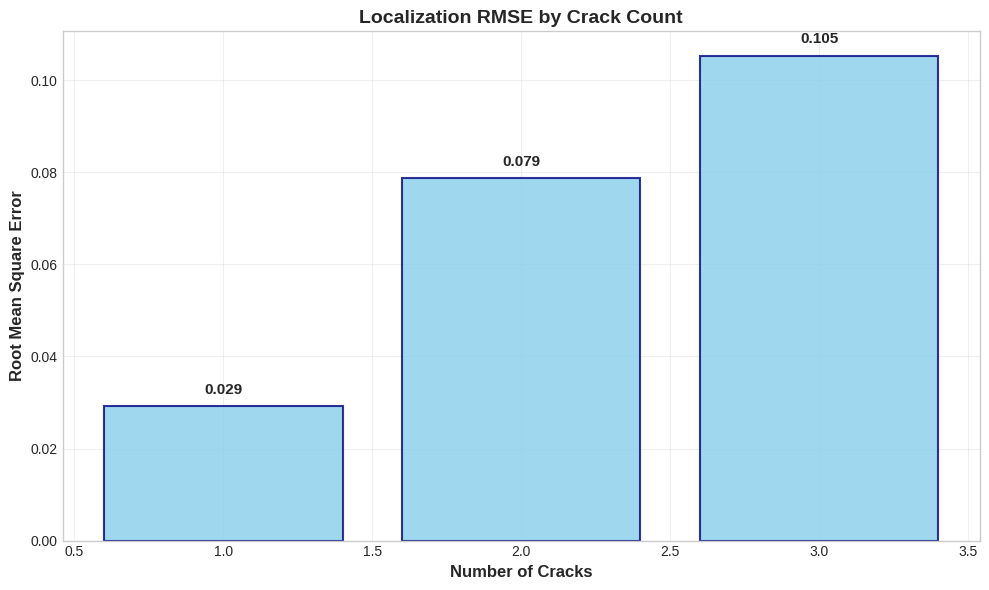

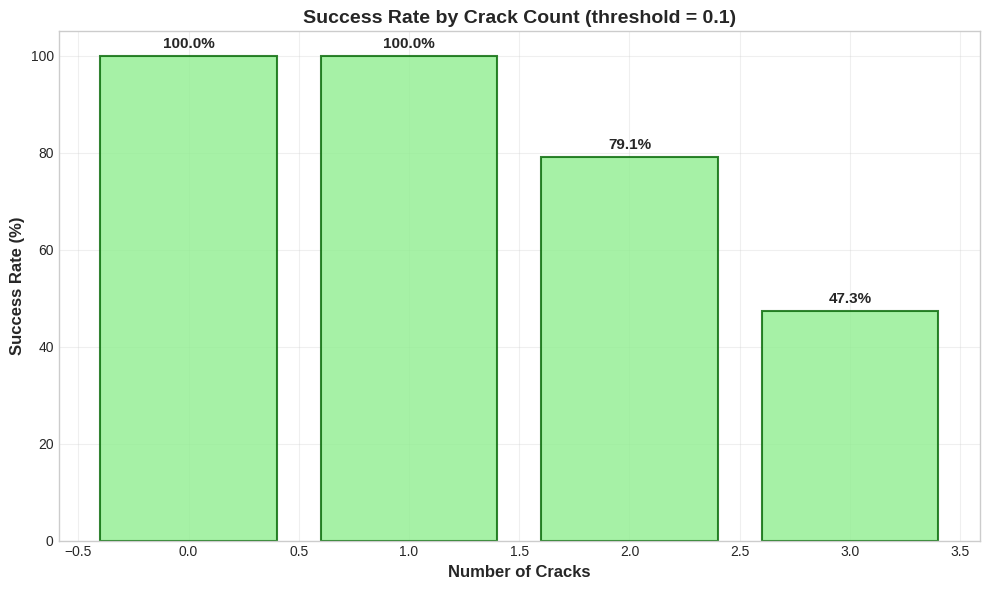

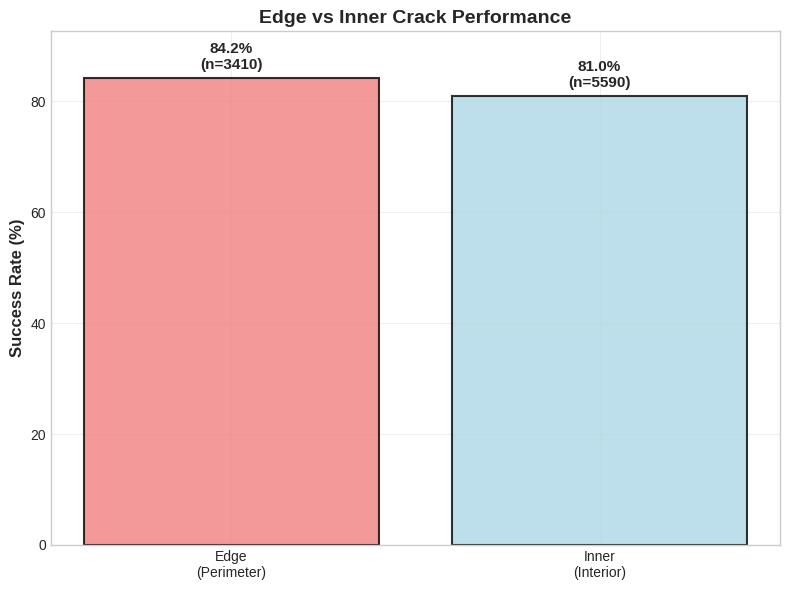

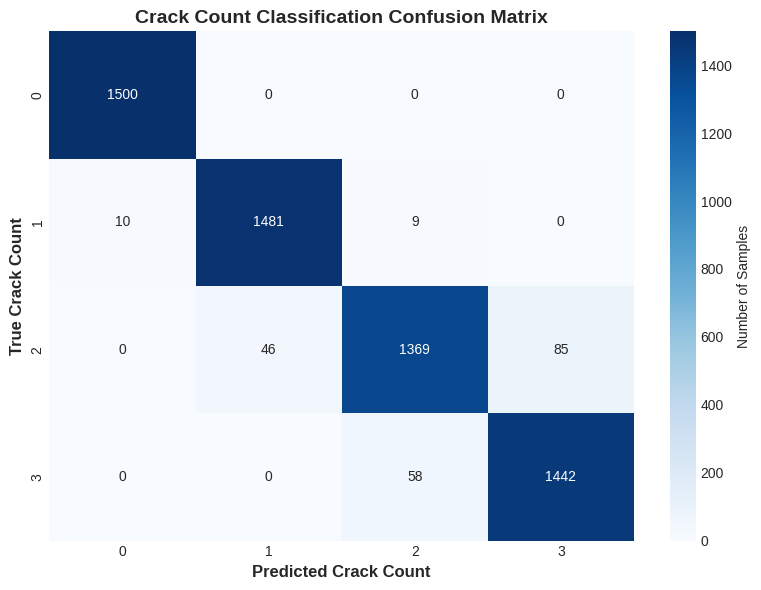

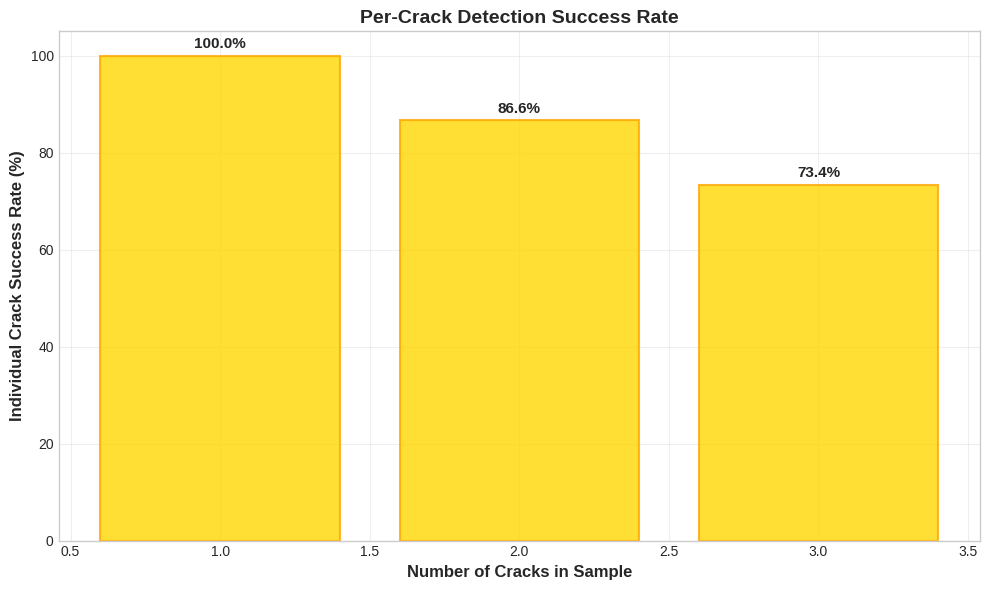

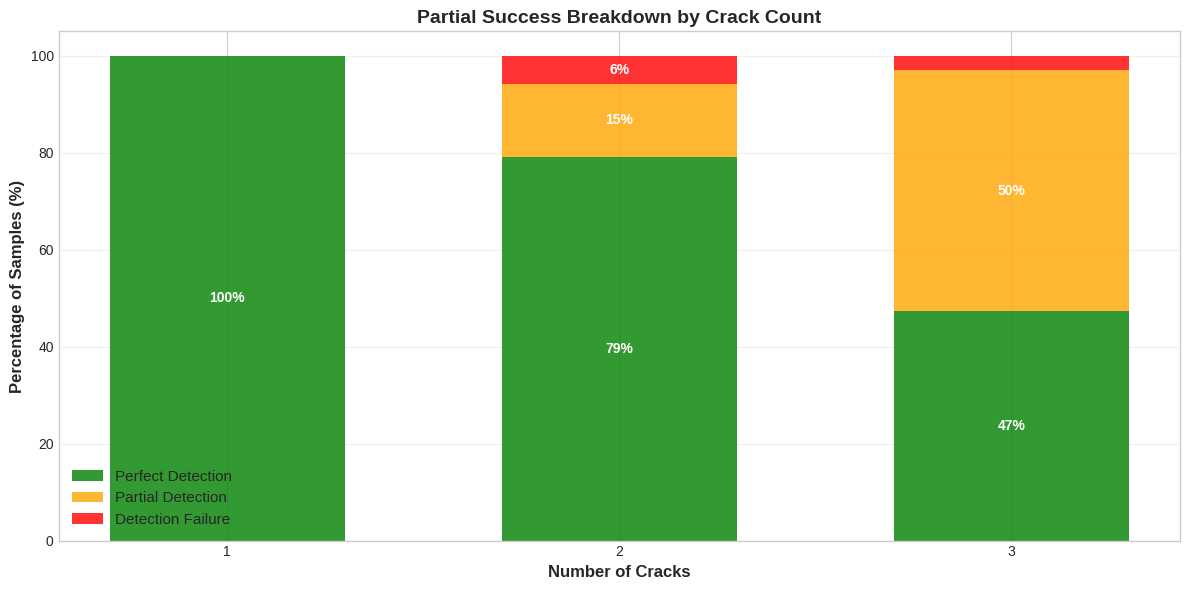

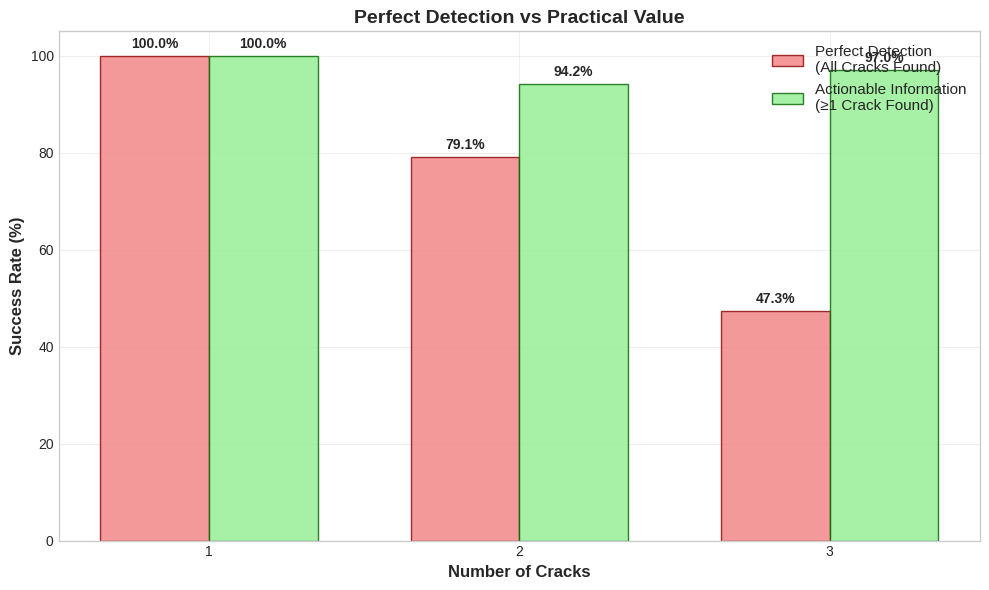

📈 Creating error distribution plot...


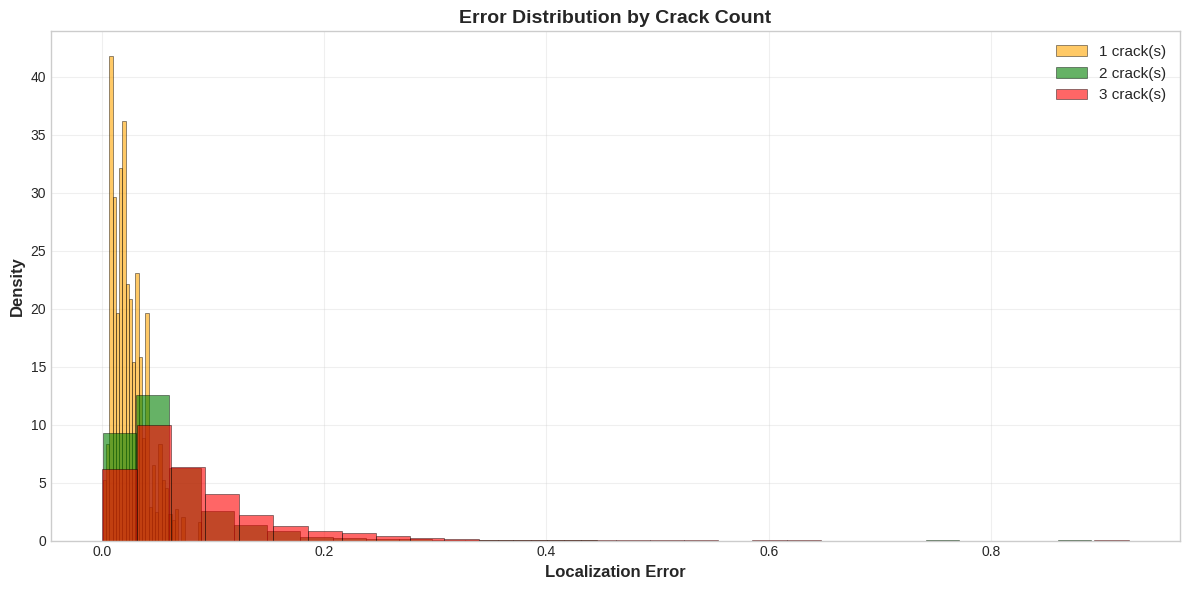

 Plots saved to: /content/drive/MyDrive/Sara_Albeyrouti_Thesis/plots/evaluation

 plot files created:
   1. rmse_by_crack_count.png
   2. success_rates_by_crack_count.png
   3. edge_vs_inner_performance.png
   4. confusion_matrix.png
   5. individual_crack_success_rates.png
   6. partial_success_breakdown.png
   7. perfect_vs_practical_value.png
   8. error_distribution.png


In [37]:
def create_visualizations():
    """Create  visualization plots"""

    # Set consistent style for all plots
    plt.style.use('seaborn-v0_8-whitegrid')

    # PLOT 1: RMSE by Crack Count


    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    crack_counts = []
    rmse_values = []
    for cc in sorted(spatial_results['by_crack_count'].keys()):
        if cc > 0:
            crack_counts.append(cc)
            rmse_values.append(spatial_results['by_crack_count'][cc]['rmse'])

    bars = ax.bar(crack_counts, rmse_values, alpha=0.8, color='skyblue',
                  edgecolor='navy', linewidth=1.5)
    ax.set_xlabel('Number of Cracks', fontsize=12, fontweight='bold')
    ax.set_ylabel('Root Mean Square Error', fontsize=12, fontweight='bold')
    ax.set_title('Localization RMSE by Crack Count', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, rmse in zip(bars, rmse_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
               f'{rmse:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'rmse_by_crack_count.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # PLOT 2: Success Rates by Crack Count

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    crack_counts_all = []
    success_rates = []
    for cc in sorted(spatial_results['by_crack_count'].keys()):
        crack_counts_all.append(cc)
        success_rates.append(spatial_results['by_crack_count'][cc][f'success_rate_{THRESHOLD:.3f}'] * 100)

    bars = ax.bar(crack_counts_all, success_rates, alpha=0.8, color='lightgreen',
                  edgecolor='darkgreen', linewidth=1.5)
    ax.set_xlabel('Number of Cracks', fontsize=12, fontweight='bold')
    ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Success Rate by Crack Count (threshold = {THRESHOLD})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
               f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'success_rates_by_crack_count.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # PLOT 3: Edge vs Inner Performance Comparison

    if edge_inner_results['edge_stats']['total'] > 0 and edge_inner_results['inner_stats']['total'] > 0:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        positions = ['Edge\n(Perimeter)', 'Inner\n(Interior)']
        success_rates_pos = [
            edge_inner_results['edge_success_rate'] * 100,
            edge_inner_results['inner_success_rate'] * 100
        ]
        colors_pos = ['lightcoral', 'lightblue']

        bars = ax.bar(positions, success_rates_pos, alpha=0.8, color=colors_pos,
                      edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Edge vs Inner Crack Performance', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max(success_rates_pos) * 1.1)

        # Add value labels and sample counts
        for i, (bar, rate) in enumerate(zip(bars, success_rates_pos)):
            total_samples = edge_inner_results['edge_stats']['total'] if i == 0 else edge_inner_results['inner_stats']['total']
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{rate:.1f}%\n(n={total_samples})', ha='center', va='bottom',
                   fontweight='bold', fontsize=11)

        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'edge_vs_inner_performance.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    cm = classification_results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=range(config.max_cracks + 1),
               yticklabels=range(config.max_cracks + 1),
               cbar_kws={'label': 'Number of Samples'})
    ax.set_xlabel('Predicted Crack Count', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Crack Count', fontsize=12, fontweight='bold')
    ax.set_title('Crack Count Classification Confusion Matrix', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # PLOT 5: Individual Crack Success Rates

    if individual_results:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        crack_counts_ind = sorted(individual_results.keys())
        individual_rates = [individual_results[cc]['individual_success_rate'] * 100 for cc in crack_counts_ind]

        bars = ax.bar(crack_counts_ind, individual_rates, alpha=0.8, color='gold',
                      edgecolor='orange', linewidth=1.5)
        ax.set_xlabel('Number of Cracks in Sample', fontsize=12, fontweight='bold')
        ax.set_ylabel('Individual Crack Success Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Per-Crack Detection Success Rate', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 105)

        # Add value labels
        for bar, rate in zip(bars, individual_rates):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'individual_crack_success_rates.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # PLOT 6: Partial Success Bars

    if individual_results:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        crack_counts = sorted(individual_results.keys())
        width = 0.6
        x = np.arange(len(crack_counts))

        # Prepare data for stacked bars
        perfect_rates = []
        partial_rates = []
        failure_rates = []

        for cc in crack_counts:
            perfect = individual_results[cc]['partial_success_rates'].get(f'{cc}_of_{cc}', 0) * 100
            failure = individual_results[cc]['partial_success_rates'].get(f'0_of_{cc}', 0) * 100
            partial = 100 - perfect - failure

            perfect_rates.append(perfect)
            partial_rates.append(partial)
            failure_rates.append(failure)

        # Create stacked bars
        bars1 = ax.bar(x, perfect_rates, width, label='Perfect Detection',
                      alpha=0.8, color='green')
        bars2 = ax.bar(x, partial_rates, width, bottom=perfect_rates,
                      label='Partial Detection', alpha=0.8, color='orange')
        bars3 = ax.bar(x, failure_rates, width,
                      bottom=[p + pa for p, pa in zip(perfect_rates, partial_rates)],
                      label='Detection Failure', alpha=0.8, color='red')

        ax.set_xlabel('Number of Cracks', fontsize=12, fontweight='bold')
        ax.set_ylabel('Percentage of Samples (%)', fontsize=12, fontweight='bold')
        ax.set_title('Partial Success Breakdown by Crack Count', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(crack_counts)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 105)

        # Add percentage labels on bars
        for i, (perfect, partial, failure) in enumerate(zip(perfect_rates, partial_rates, failure_rates)):
            if perfect > 5:  # Only show label if segment is large enough
                ax.text(i, perfect/2, f'{perfect:.0f}%', ha='center', va='center',
                       fontweight='bold', color='white')
            if partial > 5:
                ax.text(i, perfect + partial/2, f'{partial:.0f}%', ha='center', va='center',
                       fontweight='bold', color='white')
            if failure > 5:
                ax.text(i, perfect + partial + failure/2, f'{failure:.0f}%', ha='center', va='center',
                       fontweight='bold', color='white')

        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'partial_success_breakdown.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # PLOT 7: Perfect vs Practical Value Comparison

    if individual_results:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        crack_counts = sorted(individual_results.keys())
        strict_success = []
        practical_success = []

        for cc in crack_counts:
            strict = individual_results[cc]['partial_success_rates'].get(f'{cc}_of_{cc}', 0) * 100
            practical = (1 - individual_results[cc]['partial_success_rates'].get(f'0_of_{cc}', 0)) * 100
            strict_success.append(strict)
            practical_success.append(practical)

        x = np.arange(len(crack_counts))
        width = 0.35

        bars1 = ax.bar(x - width/2, strict_success, width, label='Perfect Detection\n(All Cracks Found)',
                      alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=1)
        bars2 = ax.bar(x + width/2, practical_success, width, label='Actionable Information\n(≥1 Crack Found)',
                      alpha=0.8, color='lightgreen', edgecolor='darkgreen', linewidth=1)

        ax.set_xlabel('Number of Cracks', fontsize=12, fontweight='bold')
        ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Perfect Detection vs Practical Value', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(crack_counts)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 105)

        # Add value labels
        for bars, values in [(bars1, strict_success), (bars2, practical_success)]:
            for bar, value in zip(bars, values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'perfect_vs_practical_value.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # PLOT 8: Error Distribution by Crack Count

    print("📈 Creating error distribution plot...")

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    colors = ['blue', 'orange', 'green', 'red']
    for i, crack_count in enumerate(sorted(spatial_results['raw_errors'].keys())):
        if crack_count > 0 and spatial_results['raw_errors'][crack_count]:
            errors = spatial_results['raw_errors'][crack_count]
            ax.hist(errors, bins=30, alpha=0.6, label=f'{crack_count} crack(s)',
                   color=colors[i % len(colors)], density=True, edgecolor='black', linewidth=0.5)

    ax.set_xlabel('Localization Error', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title('Error Distribution by Crack Count', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'error_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f" Plots saved to: {plot_dir}")
    print("\n plot files created:")
    print("   1. rmse_by_crack_count.png")
    print("   2. success_rates_by_crack_count.png")
    print("   3. edge_vs_inner_performance.png")
    print("   4. confusion_matrix.png")
    print("   5. individual_crack_success_rates.png")
    print("   6. partial_success_breakdown.png")
    print("   7. perfect_vs_practical_value.png")
    print("   8. error_distribution.png")

# Create all individual visualizations
create_visualizations()

In [41]:
def print_results_summary():
    """Print comprehensive results summary"""

    print("EIT CRACK LOCALIZATION - EVALUATION RESULTS")
    print("\n" + "="*80)

    # Timing Results
    print(f"\nTiming Performance:")
    print(f"   Average inference time: {timing_results['avg_individual_ms']:.2f} ms")
    print(f"   Standard deviation: {timing_results.get('std_individual_ms', 0):.2f} ms")
    print(f"   Throughput: {timing_results['samples_per_second']:.1f} samples/second")


    # Overall spatial performance
    if 'overall_regression' in spatial_results:
        overall = spatial_results['overall_regression']
        print(f"\nOverall Spatial Localization:")
        print(f"   Total crack localizations: {overall['total_localizations']:,}")
        print(f"   Mean Absolute Error (MAE): {overall['mae']:.4f}")
        print(f"   Root Mean Square Error: {overall['rmse']:.4f}")
        print(f"   Median Error: {overall['median_error']:.4f}")
        print(f"   95th Percentile Error: {overall['p95_error']:.4f}")

    # Performance by crack count
    print(f"\nPerformance by Crack Count:")
    for cc in sorted(spatial_results['by_crack_count'].keys()):
        stats = spatial_results['by_crack_count'][cc]
        crack_label = "crack" if cc == 1 else "cracks"
        print(f"\n   {cc} {crack_label} ({stats['n_samples']:,} samples):")

        if cc == 0:
            print(f"      Average distance from origin: {stats['mae']:.4f}")
            print(f"      Success rate (threshold {THRESHOLD}): {stats[f'success_rate_{THRESHOLD:.3f}']:.1%}")
        else:
            print(f"      MAE: {stats['mae']:.4f}")
            print(f"      RMSE: {stats['rmse']:.4f}")
            print(f"      Error range: {stats['min_error']:.4f} - {stats['max_error']:.4f}")
            print(f"      95th percentile: {stats['p95_error']:.4f}")
            print(f"      Success rate (threshold {THRESHOLD}): {stats[f'success_rate_{THRESHOLD:.3f}']:.1%}")

    # Edge vs Inner Analysis
    if edge_inner_results['edge_stats']['total'] > 0 and edge_inner_results['inner_stats']['total'] > 0:
        print(f"\nEdge vs Inner Performance:")
        print(f"   Edge cracks (perimeter): {edge_inner_results['edge_success_rate']:.1%} success rate, "
              f"{edge_inner_results['edge_mae']:.4f} MAE (n={edge_inner_results['edge_stats']['total']})")
        print(f"   Inner cracks (interior): {edge_inner_results['inner_success_rate']:.1%} success rate, "
              f"{edge_inner_results['inner_mae']:.4f} MAE (n={edge_inner_results['inner_stats']['total']})")


    # Classification performance
    print(f"\nCrack Count Classification:")
    print(f"   Optimal detection threshold: {classification_results['best_threshold']:.3f}")
    print(f"   Overall accuracy: {classification_results['overall_accuracy']:.1%}")
    print(f"   Count prediction MAE: {classification_results['mae']:.3f}")

    # Individual crack insights
    print(f"\nIndividual Crack Performance:")
    for cc in sorted(individual_results.keys()):
        data = individual_results[cc]
        individual_rate = data['individual_success_rate']
        all_correct = data['partial_success_rates'].get(f'{cc}_of_{cc}', 0)
        practical_value = 1 - data['partial_success_rates'].get(f'0_of_{cc}', 0)

        crack_label = "crack" if cc == 1 else "crack"
        print(f"   {cc}-{crack_label} samples:")
        print(f"      Individual crack success rate: {individual_rate:.1%}")
        print(f"      Perfect detection (all found): {all_correct:.1%}")
        print(f"      Practical value (at least 1 found): {practical_value:.1%}")
        print(f"      Mean error per crack: {data['mean_error_per_crack']:.4f}")

        if data.get('avg_inter_crack_spacing', 0) > 0:
            print(f"      Average inter-crack spacing: {data['avg_inter_crack_spacing']:.3f}")

    # Key achievements summary
    print(f"\nKey Performance Achievements:")

    # Single crack performance
    single_crack_success = spatial_results['by_crack_count'][1][f'success_rate_{THRESHOLD:.3f}']
    print(f"   Single crack detection: {single_crack_success:.1%} success rate")

    # Multi-crack practical value
    if 3 in individual_results:
        three_crack_practical = 1 - individual_results[3]['partial_success_rates'].get('0_of_3', 0)
        print(f"   Complex 3-crack scenarios: {three_crack_practical:.1%} provide actionable information")

    # Classification accuracy
    print(f"   Crack count classification: {classification_results['overall_accuracy']:.1%} accuracy")

    # Processing speed
    processing_status = "Real-time capable" if timing_results['avg_individual_ms'] < 100 else "Near real-time"
    print(f"   Processing speed: {processing_status} ({timing_results['avg_individual_ms']:.1f}ms average)")

    # Summary statistics
    if 'overall_regression' in spatial_results:
        overall = spatial_results['overall_regression']
        print(f"\nSummary Statistics:")
        print(f"   Total test samples: {len(predictions):,}")
        print(f"   Total crack localizations analyzed: {overall['total_localizations']:,}")
        print(f"   Overall localization accuracy (MAE): {overall['mae']:.4f} normalized units")
        print(f"   Classification accuracy: {classification_results['overall_accuracy']:.1%}")


# Print clean results summary
print_results_summary()

# Save all results
results_summary = {
    'timing_results': timing_results,
    'spatial_results': spatial_results,
    'edge_inner_results': edge_inner_results,
    'individual_results': individual_results,
    'classification_results': classification_results,
    'evaluation_parameters': {
        'threshold': THRESHOLD,
        'distance_thresholds': DISTANCE_THRESHOLDS,
        'test_samples': len(predictions)
    }
}

# Save comprehensive results
results_path = os.path.join(base_path, 'evaluation_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results_summary, f)

print(f"\nResults saved to: {results_path}")
print(f"Visualizations saved to: {plot_dir}")


EIT CRACK LOCALIZATION - EVALUATION RESULTS


Timing Performance:
   Average inference time: 0.10 ms
   Standard deviation: 0.00 ms
   Throughput: 836.2 samples/second

Overall Spatial Localization:
   Total crack localizations: 9,000
   Mean Absolute Error (MAE): 0.0647
   Root Mean Square Error: 0.0881
   Median Error: 0.0476
   95th Percentile Error: 0.1797

Performance by Crack Count:

   0 cracks (1,500 samples):
      Average distance from origin: 0.0028
      Success rate (threshold 0.1): 100.0%

   1 crack (1,500 samples):
      MAE: 0.0248
      RMSE: 0.0292
      Error range: 0.0009 - 0.0893
      95th percentile: 0.0546
      Success rate (threshold 0.1): 100.0%

   2 cracks (1,500 samples):
      MAE: 0.0597
      RMSE: 0.0787
      Error range: 0.0008 - 0.8899
      95th percentile: 0.1515
      Success rate (threshold 0.1): 79.1%

   3 cracks (1,500 samples):
      MAE: 0.0814
      RMSE: 0.1054
      Error range: 0.0005 - 0.9238
      95th percentile: 0.2160
      Succes